In [2]:
#@title Configuration Parameters

# NOTE: hyper-parameters must be tunned for best performance

#@markdown General Parameters
verbose = True        #@param {type: "boolean"}
seed = 1234           #@param {type: "integer"}

#@markdown DeepONet parameters
m = 200                  #@param {type: "integer"} # of sensors  
q = 10                   #@param {type: "integer"} # of sampling y's in Y
n_basis = 100            #@param {type: "integer"} # of basis functions  
branch_type = "modified" #@param ["modified", "MLP"]
trunk_type = "modified"  #@param ["modified", "MLP"]
width = 100              #@param {type: "integer"}
depth = 4                #@param {type: "integer"}
activation = "sin"       #@param ["leaky", "silu", "Rrelu", "Mish", "sin", "relu", "tanh", "selu", "gelu"]

#@markdown training parameters
learning_rate = 5e-5     #@param {type: "raw"}
batch_size = 1000        #@param {type: "integer"}
n_epochs = 5000          #@param {type: "integer"}

#@markdown Data parameters
version = "v1"
state = "voltage"
cont = "mix"

In [3]:
#@title Imports
import numpy as np
import torch

import utils.pytorch_utils as ptu

from models.nns import DeepONet
from training.supervisor import sghmc_train
from utils.data_structures import data_generator, get_data, get_traj_data
from utils.utils import compute_metrics, fraction_in_CI, init_params, l1_relative_error, l2_relative_error, plot_pred_UQ, test_sghmc, test_one, trajectory_rel_error, update_metrics_history

In [4]:
#@title Main
###################################
# Step 1: initialize the device
###################################
ptu.init_gpu(verbose=verbose)

###################################
# Step 2: initialize the device
###################################
np.random.seed(seed=seed)
torch.manual_seed(seed)

Using GPU id 0


In [5]:
###################################
# Step 3: get training and test trajectory data
###################################
train_path = "./data/trustworthydataset" + version + "/train-data-" + state + "-m-" + str(m) + "-Q-" + str(q) + "-" + cont + ".npz"
test_path = "./data/trustworthydataset" + version + "/test-data-" + state + "-m-" + str(m) + "-" + cont + ".npz"

u_train, y_train, s_train, t_sim = get_data(train_path, verbose=verbose)
u_test, y_test, s_test = get_traj_data(test_path, verbose=verbose)

if verbose:
    print("the number of testing trajectories is {}".format(len(u_test)))

Shapes are: u (17490, 200), y (17490, 1), and s (17490, 1)
Shapes are: u (600, 200), y (600, 1), and s (600, 1)
the number of testing trajectories is 750


In [6]:
###################################
# Step 4: move data to torch
###################################
u_torch_train = torch.from_numpy(u_train).float().to(ptu.device)
y_torch_train = torch.from_numpy(y_train).float().to(ptu.device)
s_torch_train = torch.from_numpy(s_train).float().to(ptu.device)

# test data
u_torch_test = []
y_torch_test = []

for k in range(len(u_test)):
    u_torch_test.append(torch.from_numpy(u_test[k]).float().to(ptu.device))
    y_torch_test.append(torch.from_numpy(y_test[k]).float().to(ptu.device))

###################################
# Step 5: define torch dataset
###################################
torch_data = data_generator(u_torch_train, y_torch_train, s_torch_train)

In [7]:
###################################
# Step 6: build DeepONet
###################################
dim = 1
n_sensors = m

branch = {}
branch["type"] = branch_type
branch["layer_size"] = [n_sensors] + [width] * depth + [n_basis]
branch["activation"] = activation

trunk = {}
trunk["type"] = trunk_type
trunk["layer_size"] = [dim] + [width] * depth + [n_basis]
trunk["activation"] = activation

model = DeepONet(branch, trunk).to(ptu.device)

if verbose:
    print(model)

DeepONet(
  (branch): modified_MLP(
    (net): ModuleList(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Linear(in_features=100, out_features=100, bias=True)
    )
    (U): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
    )
    (V): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
    )
    (activation): sin_act()
  )
  (trunk): modified_MLP(
    (net): ModuleList(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Linear(in_features=100, out_features=100, bias=True)
    )
    (U): Sequential(
      (0

In [8]:
###################################
# Step 7: define training parameters
###################################
train_params = {}
train_params["learning rate"] = learning_rate
train_params["batch size"] = batch_size
train_params["epochs"] = n_epochs
train_params["print every"] = 10
train_params["N"] = u_train.shape[0]
train_params["use grad norm"] = True
train_params["grad norm"] = 1e2
train_params["burn in"] = 1000
train_params["size test history"] = 100

###################################
# Step 8: define sghmc parameters
###################################
sghmc_params = {}
sghmc_params["eta"] = 1e-5
sghmc_params["v"] = .1
sghmc_params["alpha"] = .1
sghmc_params["beta"] = .5 * sghmc_params["v"] * sghmc_params["eta"]
sghmc_params["self sigma"] = np.sqrt(2.0 * (sghmc_params["alpha"] - sghmc_params["beta"]) * sghmc_params["eta"])
tau = 1e-4
sghmc_params["self sigma"] *= np.sqrt(tau)
sghmc_params["sigma"] = 2.5

if verbose:
    print("beta = {:.8f}".format(sghmc_params["beta"]))
    print("alpha = {:.8f}".format(sghmc_params["alpha"]))
    print("self sigma = {:.8f}".format(sghmc_params["self sigma"]))

###################################
# Step 9: define metrics and losses
###################################
metrics = [l1_relative_error, l2_relative_error]
L1_history = {}
L1_history["max"] = []
L1_history["min"] = []
L1_history["mean"] = []
L2_history = {}
L2_history["max"] = []
L2_history["min"] = []
L2_history["mean"] = []

###################################
# Step 10: initial test
###################################
n_test_samples = 100
u_torch_test_100 = u_torch_test[:n_test_samples]
y_torch_test_100 = y_torch_test[:n_test_samples]
s_test_100 = s_test[:n_test_samples]

# we perform an initial test for the probabilistic model
s_pred = test_sghmc(model, u_torch_test_100, y_torch_test_100)
metrics_state = compute_metrics(s_test_100, s_pred, metrics, verbose=verbose)
L1_history = update_metrics_history(L1_history, metrics_state[0])
L2_history = update_metrics_history(L2_history, metrics_state[1])
del metrics_state

beta = 0.00000050
alpha = 0.10000000
self sigma = 0.00001414
l1-relative errors: max=708.616, min=230.178, mean=425.566
l2-relative errors: max=714.489, min=237.638, mean=427.674


In [9]:
###################################
# Step 11: training
###################################
logger, loss_history = sghmc_train(
    model,
    torch_data,
    train_params,
    sghmc_params=sghmc_params,
    verbose=verbose,
    test_data=(u_torch_test_100, y_torch_test_100, s_test_100),
    loss_history=(L1_history, L2_history),
    metrics=metrics,
    device=ptu.device,
    )


***** SGHMC Training for 5000 epochs and using 17490 data samples*****



  0%|          | 0/5000 [00:00<?, ?it/s]

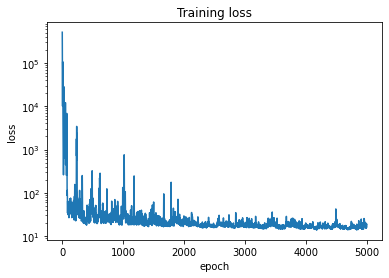

In [10]:
#@title Postprocessing
import matplotlib.pyplot as plt

plt.figure()
plt.semilogy(logger["ge"])
plt.title("Training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

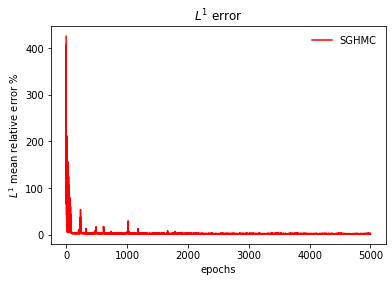

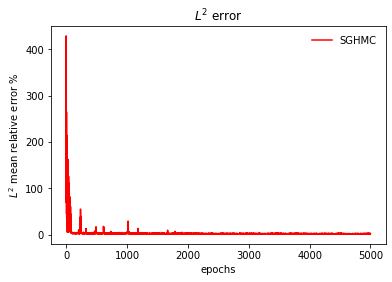

In [11]:
# L1 plot
plt.figure()
plt.plot(L1_history["mean"], "r-", label = "SGHMC")
plt.legend(framealpha=1, frameon=False)
plt.xlabel("epochs")
plt.ylabel("$L^1$ mean relative error %")
plt.title("$L^1$ error")
plt.show()

# L2 plot
plt.figure()
plt.plot(L2_history["mean"], "r-", label = "SGHMC")
plt.legend(framealpha=1, frameon=False)
plt.xlabel("epochs")
plt.ylabel("$L^2$ mean relative error %")
plt.title("$L^2$ error")
plt.show()

% of the true traj. within the error bars is 100.000
% of the true traj. within the error bars is 100.000
% of the true traj. within the error bars is 100.000
ratios-[max, min, mean] = [100.0, 6.333333333333334, 86.625]
Best mean relative errors: L1=1.90323 and L2=2.33356
Standard deviation of relative errors: L1=1.94624 and L2=2.49127


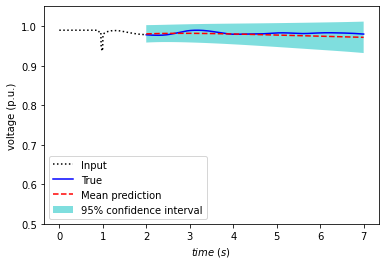

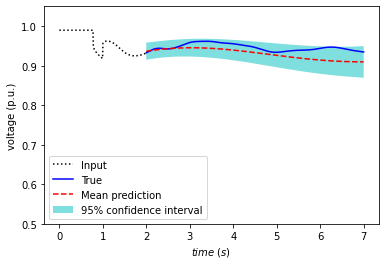

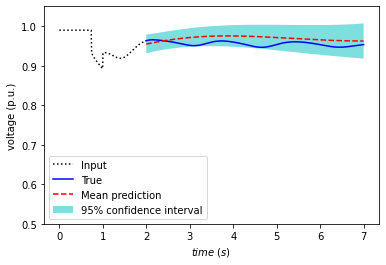

In [12]:
#@title Testing and UQ
###################################
# Step 1: define functions for testing and UQ
###################################
def extract(history, k):
    return [item[k] for item in history]

def eval_trajs(history, num, sensors, s, u, y, ratios, preds, errs, L1_test, L2_test, plot_num_traj=None, verbose=True):
    for k in range(num):
        pred_vec = np.hstack(extract(history, k))
        pred_i = np.mean(pred_vec, axis=-1)
        err_i = np.std(pred_vec, axis=-1)
        if k in plot_num_traj:
            plot_pred_UQ(sensors, u[k][0,:].reshape(-1,), y[k], s[k].reshape(-1,), pred_i.reshape(-1,), err_i.reshape(-1,), xlabel="$time~(s)$", ylabel="voltage (p.u.)", v_lims=False)
            verbose_i = True
        else:
            verbose_i = False
        ratio = fraction_in_CI(s[k].reshape(-1,), pred_i.reshape(-1,), err_i.reshape(-1,), verbose=verbose_i)
        l1_error, l2_error =  trajectory_rel_error(s[k].reshape(-1,), pred_i.reshape(-1,), verbose=False) 
        # updating logs
        preds.append(pred_i)
        errs.append(err_i)
        ratios.append(ratio)
        L1_test.append(l1_error)
        L2_test.append(l2_error)
    if verbose:
        print("ratios-[max, min, mean] = [{}, {}, {}]".format(100 * np.max(ratios), 100 * np.min(ratios), 100 * np.mean(ratios)))
        
        mean_L1 = np.round(100 * np.mean(L1_test), decimals=5)
        std_L1 = np.round(100 * np.std(L1_test), decimals=5)
        mean_L2 = np.round(100 * np.mean(L2_test), decimals=5)
        std_L2 = np.round(100 * np.std(L2_test), decimals=5)
        print("Best mean relative errors: L1={} and L2={}".format(mean_L1, mean_L2))
        print("Standard deviation of relative errors: L1={} and L2={}".format(std_L1, std_L2))
    
    return ratios, preds, errs, L1_test, L2_test

L1_test = []
L2_test = []
mean_test = []
std_test = []
ratios = []

###################################
# Step 2: define input and number of test trajectories
###################################
t_input = np.linspace(0, 2.0, num=m)[:, None]
n_test_trajs = 100
plot_num_traj = [1, 10, 80]

###################################
# Step 2: evaluate trajectories
###################################
ratios, mean_test, std_test, L1_test, L2_test = eval_trajs(
    logger["pred test"], 
    n_test_trajs,
    t_input,
    s_test,
    u_test,
    y_test,
    ratios,
    mean_test,
    std_test,
    L1_test,
    L2_test,
    plot_num_traj=plot_num_traj,
    verbose=verbose,
)
